In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
drone_path_1 = '../../data/40mtest/*.wav'
#drone_path_10 = '../../data/10mtest/*.wav'
#drone_path_20 = '../../data/20mtest/*.wav'
#drone_path_30 = '../../data/30mtest/*.wav'
#drone_path_40 = '../../data/40mtest/*.wav'
#drone_path_50 = '../../data/50mtest/*.wav'
#background_path = '../../data/backgroundtest/*.wav'

drone_files_1 = glob.glob(drone_path_1)
#drone_files_10 = glob.glob(drone_path_10)
#drone_files_20 = glob.glob(drone_path_20)
#drone_files_30 = glob.glob(drone_path_30)
#drone_files_40 = glob.glob(drone_path_40)
#drone_files_50 = glob.glob(drone_path_50)
#background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
drone_raw_1 = load(drone_files_1)
#drone_raw_10 = load(drone_files_10)
#drone_raw_20 = load(drone_files_20)
#drone_raw_30 = load(drone_files_30)
#drone_raw_40 = load(drone_files_40)
#drone_raw_50 = load(drone_files_50)

#background_raw = load(background_files)

(145839,)


In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print(i,">small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_drone_1, y_drone_1 = mfcc4(drone_raw_1, 1)
#mfcc_drone_10, y_drone_10 = mfcc4(drone_raw_10, 3)
#mfcc_drone_20, y_drone_20 = mfcc4(drone_raw_20, 2)
#mfcc_drone_30, y_drone_30 = mfcc4(drone_raw_30, 2)
#mfcc_drone_40, y_drone_40 = mfcc4(drone_raw_40, 1)
#mfcc_drone_50, y_drone_50 = mfcc4(drone_raw_50, 1)

#mfcc_background, y_background = mfcc4(background_raw, 0)

(145839,)
139264 >small end: (16, 13)
143360 >small end: (16, 5)


In [8]:
print(mfcc_drone_1.shape, y_drone_1.shape)
#print(mfcc_drone_10.shape, y_drone_10.shape)
#print(mfcc_drone_20.shape, y_drone_20.shape)
#print(mfcc_drone_30.shape, y_drone_30.shape)
#print(mfcc_drone_40.shape, y_drone_40.shape)
#print(mfcc_drone_50.shape, y_drone_50.shape)
#print(mfcc_background.shape, y_background.shape)

(34, 16, 16) (34,)


In [9]:
#X = np.concatenate((mfcc_drone_1,mfcc_drone_10,mfcc_drone_20,mfcc_drone_30,mfcc_drone_40,mfcc_drone_50, mfcc_background), axis=0)
#y = np.hstack((y_drone_1, y_drone_10, y_drone_20, y_drone_30, y_drone_40, y_drone_50, y_background))

X = np.concatenate((mfcc_drone_1), axis=0)
y = np.hstack((y_drone_1))

print(X.shape, y.shape)

(544, 16) (34,)


In [10]:
X_test = np.reshape(X,(-1,256))
print(X_test.shape)
print(type(X_test))

(34, 256)
<class 'numpy.ndarray'>


In [11]:
#X_train2 = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) ############# 리셰입 해야 

In [12]:
n_labels = y.shape[0]
n_unique_labels = 5
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(34, 5)


# test init

In [13]:
tf.reset_default_graph()

In [14]:
n_mfcc = 16
n_frame = 16
n_classes = 5
n_channels = 1

kernel_size = 3
stride = 1
pad = "SAME"

learning_rate = 0.0002

In [15]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
#X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels]) #fully connected에는 리셰입 안해도 된다 
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

#dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
#dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=True)
dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)
dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)
#이거 지워보고 돌려보고 
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)
dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)

logits= tf.layers.dense(inputs=dropout5, units=5)

In [16]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [17]:
# Model Save
sess=tf.Session()
saver = tf.train.Saver()
saver.restore(sess, '../../model/DNN/4_dense_model')

INFO:tensorflow:Restoring parameters from ../../model/DNN/4_dense_model


In [18]:
# Prediction
y_test = sess.run(tf.nn.softmax(logits), feed_dict={X: X_test, keep_prob:1})
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test , keep_prob:1}) 
y_true = sess.run(tf.argmax(y_encoded,1))
print(type(y_test))

<class 'numpy.ndarray'>


In [19]:
import pandas as pd
pd.options.display.max_rows = 4000
print(pd.DataFrame(y_test))


           0         1         2         3         4
0   0.030994  0.014204  0.929958  0.024825  0.000019
1   0.045487  0.017063  0.915552  0.021855  0.000043
2   0.059426  0.024443  0.896031  0.020025  0.000076
3   0.235863  0.017953  0.737834  0.007625  0.000725
4   0.060491  0.015826  0.907416  0.016225  0.000041
5   0.526704  0.010455  0.462225  0.000388  0.000228
6   0.284687  0.016457  0.692915  0.005103  0.000838
7   0.297688  0.019135  0.677588  0.004595  0.000994
8   0.235408  0.018304  0.737261  0.008154  0.000873
9   0.049752  0.013032  0.919418  0.017771  0.000027
10  0.270548  0.021418  0.701031  0.005947  0.001057
11  0.054272  0.026694  0.897372  0.021595  0.000067
12  0.241837  0.026393  0.722175  0.008322  0.001274
13  0.069278  0.015015  0.899667  0.015977  0.000063
14  0.041600  0.016222  0.922209  0.019944  0.000025
15  0.200286  0.037978  0.748804  0.011374  0.001557
16  0.508427  0.014657  0.476364  0.000359  0.000193
17  0.585014  0.006453  0.408216  0.000203  0.

F-Score: 0.0
Accuracy:  0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00        34
   macro avg       0.00      0.00      0.00        34
weighted avg       0.00      0.00      0.00        34

[[ 0  0  0]
 [ 6  0 28]
 [ 0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


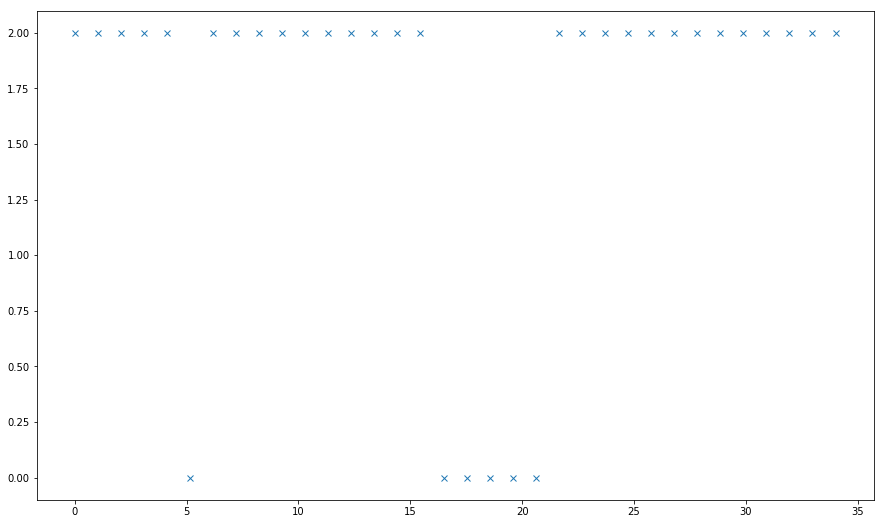

In [20]:
# Print Result

from sklearn.metrics import precision_recall_fscore_support
y_true = y_true
y_pred = y_pred

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,2))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))


#fig = plt.figure(figsize=(15,9))
#ax = fig.add_subplot(1,1,1)
#ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true, 'x')


fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred, 'x')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

In [21]:
from sklearn.metrics import confusion_matrix
print(y_pred)
mat = confusion_matrix(y_true, y_pred)0 0 0 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

SyntaxError: invalid syntax (<ipython-input-21-64a22509ac47>, line 3)

In [ ]:
print(mat)

In [ ]:
print(mat[0])